In [1]:
import json
import csv

import sys
sys.path.append("../../")
#sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

torch.set_default_tensor_type(torch.DoubleTensor)

import implicitmodules.torch as dm
from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian

In [2]:
from PIL import Image
path_image = '/home/gris/Data/Multishape/'
source = torch.tensor(np.asarray(Image.open(path_image + "Lung_Moving.tif")))
target = torch.tensor(np.asarray(Image.open(path_image + "Lung_Fixed.tif")))

# load boundaries from csv file
from numpy import loadtxt
boundary0 = torch.tensor(loadtxt('boundary0.csv', delimiter=','))
boundary1 = torch.tensor(loadtxt('boundary1.csv', delimiter=','))

In [3]:
# convert the rgb image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

source = torch.tensor(rgb2gray(source))
target = torch.tensor(rgb2gray(target))

In [4]:
source.shape, target.shape

(torch.Size([400, 400]), torch.Size([404, 408]))

In [5]:
# cropping the target so source and target are of the same size
target = target[2:-2, 4:-4]
target.shape

torch.Size([400, 400])

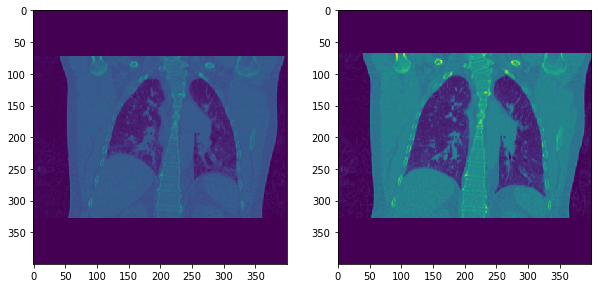

In [7]:
plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(source)
plt.plot(boundary0[1,:], boundary0[0,:], '.')
plt.plot(boundary1[1,:], boundary1[0,:], '.')


plt.subplot(1, 2, 2)
plt.imshow(target)


plt.show()

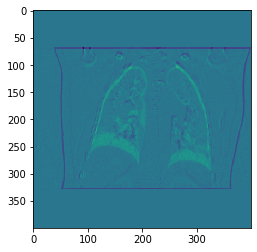

In [10]:
plt.imshow(source - target)

In [17]:
boundary0 = dm.MultiShape.Boundary(boundary0)
boundary1 = dm.MultiShape.Boundary(boundary1)

source_deformable = dm.Models.DeformableImage(source)
target_deformable = dm.Models.DeformableImage(target)

module0 = 
module1 = 
module_bg = 

#we need attachment terms which take into account the segmentation
attach0 = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()
attach1 = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()
attachBg = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()

shoot_solver = 'torch_euler'
shoot_it = 10

compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold(
    [dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module0.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module1.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module_bg.manifold.clone(requires_grad=True), [boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]])])


In [41]:
a = source -target
a = torch.mul(a, a)

In [42]:
a

tensor([[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000, 52430.5123, 52430.5123,  ..., 52430.5123, 52430.5123,
             0.0000],
        [    0.0000, 52430.5123,     0.0000,  ...,     0.0000, 52430.5123,
             0.0000],
        ...,
        [    0.0000, 52430.5123,     0.0000,  ...,     0.0000, 52430.5123,
             0.0000],
        [    0.0000, 52430.5123, 52430.5123,  ..., 52430.5123, 52430.5123,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000]])

In [31]:
source.shape, a.shape

(torch.Size([400, 400]), torch.Size([]))